# Brazill Zika Microcephaly Cases Analysis

<img src="lasdpc-logo.png" alt="Drawing"/>

In [56]:
'''
Distributed Systems and Concurrent Programming Laboratory (LaSDPC)
Institute of Mathematical and Computer Sciences
University of São Paulo
Authors: Vinícius Aires Barros
         Gabriel Tomiatti
         Ana Spengler
'''

import os, shutil, csv, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from pyspark.mllib.clustering import KMeans

In [57]:
def list2csv(arr_input):
    '''Method for converting python list into csv file'''
    output = io.StringIO("")
    csv.writer(output).writerow(arr_input)
    return output.getValue().strip()

def csv2rdd(csv):
    '''Method for converting csv file into rdd'''
    return sc.parallelize(csv)

def rdd2numpy_arr(rdd_input):
    '''Method for converting rdd into numpy array'''
    return np.asarray(rdd.collect())

def save_result(dir_path, rdd_input):
    '''Method for save rdd result into specific folder'''
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    rdd_input.saveAsTextFile(dir_path)

def kmeans_error(point, clusters_rdd): 
    '''Method for evaluate the kmeans algorithm error'''
    center = clusters_rdd.centers[clusters_rdd.predict(point)] 
    return sqrt(sum([x**2 for x in (point - center)]))    

def show_rdd(x):
    '''Method for show the RDD content'''
    print(x)

### Read and Show Zika Virus Dataset in Pandas
(Example of how to read csv data and show pandas dataframe)

In [58]:
#Show Zika Table Content
input_path = 'dataset/lista_dados_sage_origin_headers.csv'
file_input_pd = pd.read_csv(input_path, delimiter=',')

file_input_pd.shape

(67243, 11)

In [59]:
#Show Table Content
file_input_pd

,ibge,nu_249na,26t1_0umulado,26t1_inv7tig0ao,26t1_confir9do,26t1_d7cartado,26t1_obi26_notificado,26t1_obi26_inv7tigado,26t1_obi26_confir9do,26t1_obi26_d7cartado,uf
0,120001,6,0,0,0,0,0,0,0,0,0
1,120005,6,0,0,0,0,0,0,0,0,0
2,120010,6,0,0,0,0,0,0,0,0,0
3,120010,37,1,1,0,0,0,0,0,0,0
4,120010,38,1,1,0,0,0,0,0,0,0
5,120010,39,1,1,0,0,0,0,0,0,0
6,120010,40,1,1,0,0,0,0,0,0,0
7,120010,41,1,1,0,0,0,0,0,0,0
8,120010,42,1,1,0,0,0,0,0,0,0
9,120010,43,1,1,0,0,0,0,0,0,0


### Read Zika Virus Dataset in Apache Spark

In [60]:
input_rdd = sc.textFile(input_path)
print("Size of dataset:", input_rdd.count(), "rows")

Size of dataset: 67244 rows


In [62]:
#Remove Header of CSV
header = input_rdd.first()
input_rdd = input_rdd\
    .filter(lambda row : row != header)    
print(header)

ibge,nu_249na,26t1_0umulado,26t1_inv7tig0ao,26t1_confir9do,26t1_d7cartado,26t1_obi26_notificado,26t1_obi26_inv7tigado,26t1_obi26_confir9do,26t1_obi26_d7cartado,uf


In [63]:
#Converting CSV RDD data into RDD Array
zika_rdd = input_rdd\
    .map(lambda line: np.array([int(row) for row in line.split(',')]))

#Get distinct ibge numbers
ibge_numbers = input_rdd\
    .map(lambda line: [int(row) for row in line.split(',')][0])\
    .distinct()\
    .collect()

#Sorting Zika Cases Ascending by IBGE Number
zika_sorted_rdd = zika_rdd\
    .sortBy(lambda row : row[0])
    
cities_last_week_zika_rdd = zika_sorted_rdd\
    .filter(lambda row : row[1] == 50)

# Top 10 Cities of Zika Case order by DESC

In [64]:
#Top 10 Zika Under Study Cases by Cities order by desc
top10_desc_zika_city_under_study = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : -row[3])

#Top 10 Zika Case by Cities order by desc
top10_desc_zika_city_cases = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : -row[4])

#Top 10 Zika Case Discarted by Cities order by desc
top10_desc_zika_city_discarted = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : -row[5])
        
#Top 10 Zika Case of Deaths by Cities order by desc
top10_desc_zika_city_deaths = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[6])

#Top 10 Case of Study Deaths by Cities order by desc
top10_desc_zika_city_death_study = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[7])

#Top 10  Case of Confirmed Deaths by Cities order by desc
top10_desc_zika_city_death_confirmed = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[8])

#Top 10 Case of Discarted Deaths by Cities order by desc
top10_desc_zika_city_death_discarded = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[9])

# Top 10 Cities of Zika Case order by ASC

In [65]:
#Top 10 Zika Under Study Cases by Cities order by Asc
top10_asc_zika_city_under_study = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : row[3])

#Top 10 Zika Case by Cities order by Asc
top10_asc_zika_city_cases = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : row[4])

#Top 10 Zika Case Discarted by Cities order by Asc
top10_asc_zika_city_discarted = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : row[5])
        
#Top 10 Zika Case of Deaths by Cities order by Asc
top10_asc_zika_city_deaths = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: row[6])

#Top 10 Case of Study Deaths by Cities order by Asc
top10_asc_zika_city_death_study = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: row[7])

#Top 10  Case of Confirmed Deaths by Cities order by Asc
top10_asc_zika_city_death_confirmed = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: row[8])

#Top 10 Case of Discarted Deaths by Cities order by Asc
top10_asc_zika_city_death_discarded = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: row[9])

# Sum Total of Cases by Region

In [114]:
br_state_region = {
    "Norte":[0, 2, 3, 13, 19, 21, 26],
    "Nordeste":[1, 4, 5, 9, 14, 15, 16, 20, 24],
    "Centro-Oeste":[6, 8, 11, 12],
    "Sudeste":[7, 10, 18, 25],
    "Sul":[17, 22, 23]
}

In [178]:
total_death_region = {"Norte":0, "Nordeste":0, "Centro-Oeste":0, "Sudeste":0, "Sul":0}
total_death_by_state = []

for i in range (0, 27):
    sum_value = cities_last_week_zika_rdd\
        .filter(lambda row : row[10] == i)\
        .map(lambda row : row[6]).sum()
    total_death_by_state.append(sum_value)
    
total_death_country = sum(total_death_by_state)

for key in br_state_region:
    sum_region = 0
    for index in br_state_region[key]:
        total_death_region[key] += total_death_by_state[index]

## Applying KMeans Algorithm

In [172]:
#Compare diferents solution for clustering parameters
clusters_rdd = KMeans.train(cities_last_week_zika_rdd, 100, maxIterations=100, initializationMode='random')

In [173]:
#Calculate K-Means Algorithm Error
WSSSE = cities_last_week_zika_rdd\
            .map(lambda point: kmeans_error(point, clusters_rdd))\
            .reduce(lambda x, y: x + y)
        
print('Within Set Sum of Squared Error = ' + str(WSSSE))

Within Set Sum of Squared Error = 630684.579172


# Chart Ploting Analysis

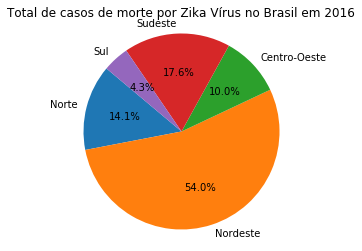

In [179]:
#Ploting Pie Chart
labels_pie = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]
sizes_pie = [total_death_region[key] for key in total_death_region]
plt.pie(sizes_pie, labels=labels_pie, autopct='%1.1f%%', startangle=140)
plt.title("Total de casos de morte por Zika Vírus no Brasil em 2016")
plt.axis('equal')
plt.show()

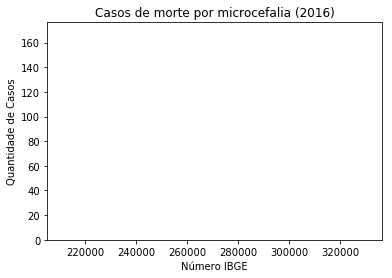

In [183]:
x_city = [x[0] for x in top10_desc_zika_city_cases]
y_zika = [x[4] for x in top10_desc_zika_city_cases]

plt.bar(x_city, y_zika, label='Casos de Zika Vírus')
plt.xlabel('Número IBGE')
plt.ylabel('Quantidade de Casos')
plt.title('Casos de morte por microcefalia (2016)')
plt.show()